# Calibration curves

## Load packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

## Load data

In [33]:
#SMOTE = False
K_NEIGHBOURS = 5
N_SPLITS = 10
TUNE = True
directory = '../../Data/tidy_data/'

# Set up k-fold splits
number_of_splits = 10

In [34]:
FILENAME = 'ml_during_hypo_5.csv' #'ml_during_glyc_ts.csv'
df = pd.read_csv(directory + FILENAME)
df.day_of_week = df.day_of_week.astype(str)
df.day = df.day.astype(str)
df['season'] = (df.month%12 // 3 + 1).astype(str)
target_column = 'y_hypo'
strat = df['stratify']
df.drop(columns=['ID', 'month', 'stratify', 'bout_id'], inplace=True)
df.dropna(inplace=True, subset=['start_glc','duration'])

In [3]:
FILENAME = 'ml_during_hypo_5.csv'
df = pd.read_csv(directory + FILENAME)
target_columns = 'y_hypo'
df.dropna(inplace=True, subset=['start_glc','duration'])

In [35]:
def assess_calibration(X, y, model, number_of_splits, smote=False):
    """
        
    """

    # Convert data to NumPy arrays (required for stratified k-fold)
    X_np = X.values
    y_np = y.values
    
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, 
                        random_state=42)
    skf.get_n_splits(X_np, y_np)

    # Define bins
    number_of_bins = 10

    # Set up results DataFrames (to get results from each run)
    results_model_probability = []
    results_fraction_positive = []

    # Loop through the k-fold splits
    loop_counter = 0
    for train_index, test_index in skf.split(X_np, y_np):    
            
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        if smote:
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        # Set up and fit model
        model.fit(X_train,y_train)
        
        # Get test set proabilities
        y_calibrate_probabilities = model.predict_proba(X_test)[:,1]
        
        # Get calibration curve (use quantile to make sure all bins exist)
        fraction_pos, model_prob = calibration_curve(
            y_test, y_calibrate_probabilities, 
            n_bins=number_of_bins,
            strategy='quantile')    

        # record run results
        results_model_probability.append(model_prob)
        results_fraction_positive.append(fraction_pos)
        
        # Increment loop counter
        loop_counter += 1
        
    # Convert results to DataFrame
    results_model_probability = pd.DataFrame(results_model_probability)
    results_fraction_positive = pd.DataFrame(results_fraction_positive)

    return results_model_probability, results_fraction_positive

In [36]:
def get_calibration_curve(results_model_probability, results_fraction_positive, number_of_splits): 
        """
        
        """
        fig, ax = plt.subplots()

        # Add individual k-fold runs
        for run in range(number_of_splits):
                ax.plot(results_model_probability.loc[run],
                        results_fraction_positive.loc[run],
                        linestyle='--',
                        linewidth=0.75,
                        color='0.5')

        # Add mean
        ax.plot(results_model_probability.mean(axis=0),
                results_fraction_positive.mean(axis=0),
                linestyle='-',
                linewidth=2,
                color='darkorange',
                label='mean')

        # Add diagonal
        ax.plot([0, 1], [0, 1],
                linestyle='--',
                label='theoretical')

        ax.set_xlabel('Model probability')
        ax.set_ylabel('Fraction positive')

        ax.set_title('Reliability plot')

        ax.grid()
        ax.legend()
        
        return fig


## Logistic regression - Simple model

In [51]:
X = df[['start_glc','duration']]
y = df[target_columns]
model = LogisticRegression(C=0.06662641355374649, solver='liblinear')

### Without SMOTE

In [52]:
results_model_probability_simple_model, results_fraction_positive_simple_model = assess_calibration(X, y, model, number_of_splits, False)

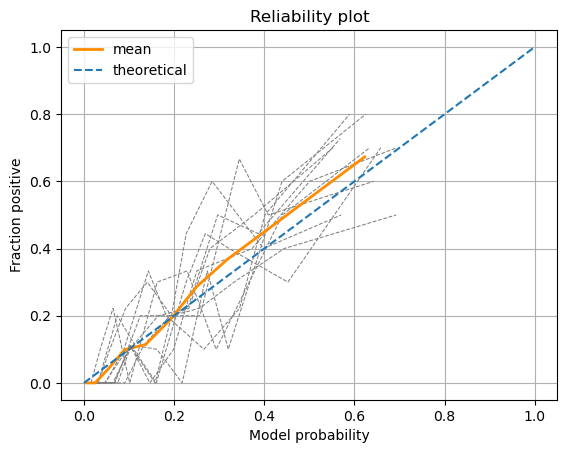

In [53]:
fig = get_calibration_curve(results_model_probability_simple_model, results_fraction_positive_simple_model, number_of_splits)

### With SMOTE

In [54]:
results_model_probability_simple_model_smote, results_fraction_positive_simple_model_smote = assess_calibration(X, y, model, number_of_splits, True)

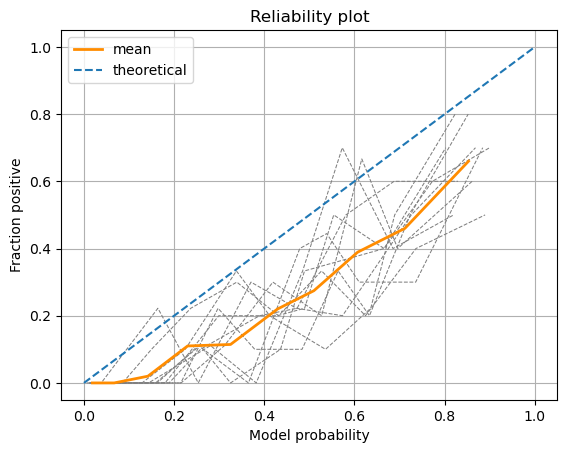

In [55]:
fig = get_calibration_curve(results_model_probability_simple_model_smote, results_fraction_positive_simple_model_smote, number_of_splits)

## XGBoost advanced model

In [38]:
X = df.drop(columns=target_column)
y = df[target_columns]
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### Without SMOTE

In [47]:
%%capture

results_model_probability_complex_model, results_fraction_positive_complex_model = assess_calibration(X, y, XGBClassifier(), number_of_splits, False)

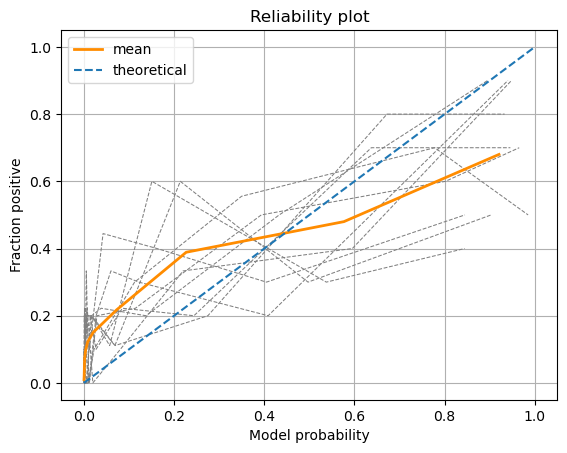

In [48]:
fig = get_calibration_curve(results_model_probability_complex_model, results_fraction_positive_complex_model, number_of_splits)

### With SMOTE

In [49]:
%%capture

results_model_probability_complex_model_smote, results_fraction_positive_complex_model_smote = assess_calibration(X, y, XGBClassifier(), number_of_splits, True)

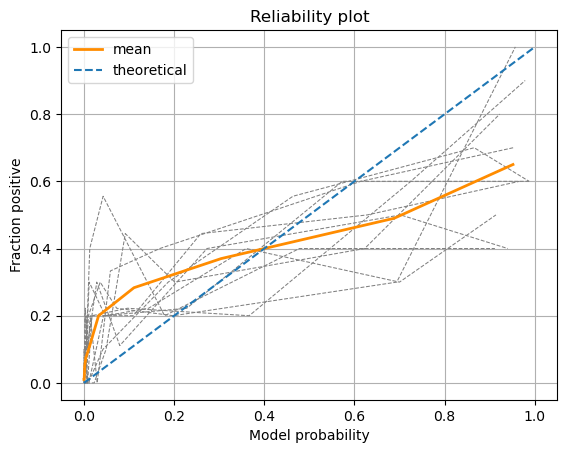

In [50]:
fig = get_calibration_curve(results_model_probability_complex_model_smote, results_fraction_positive_complex_model_smote, number_of_splits)